In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('./train.csv', encoding = 'big5')

In [3]:
data = data.iloc[:, 3:]
data[data == 'NR'] = 0
raw_data = data.to_numpy()

In [4]:
month_data = {}
for month in range(12):
    sample = np.empty([18, 480]) # 18 datas each day
    for day in range(20): # only 20 days per months
        # 24 hours
        sample[:, day * 24 : (day + 1) * 24] = raw_data[18 * (20 * month + day) : 18 * (20 * month + day + 1), :]
    month_data[month] = sample

In [5]:
x = np.empty([12 * 471, 18 * 9], dtype = float)
y = np.empty([12 * 471, 1], dtype = float)
for month in range(12):
    for day in range(20):
        for hour in range(24):
            if day == 19 and hour > 14: #20days:0-19, 24hours:0-23, only support 471 index = 19*24 + 24-9
                continue
            x[month * 471 + day * 24 + hour, :] = month_data[month][:,day * 24 + hour : day * 24 + hour + 9].reshape(1, -1) #vector dim:18*9 (9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9)
            y[month * 471 + day * 24 + hour, 0] = month_data[month][9, day * 24 + hour + 9] #value 9th is PM2.5 in features


In [6]:
mean_x = np.mean(x, axis = 0) #18 * 9 
std_x = np.std(x, axis = 0) #18 * 9 
for i in range(len(x)): #12 * 471
    for j in range(len(x[0])): #18 * 9 
        if std_x[j] != 0:
            x[i][j] = (x[i][j] - mean_x[j]) / std_x[j]

In [7]:
import math
x_train_set = x[: math.floor(len(x) * 0.8), :]
y_train_set = y[: math.floor(len(y) * 0.8), :]
x_validation = x[math.floor(len(x) * 0.8): , :]
y_validation = y[math.floor(len(y) * 0.8): , :]
print(x_train_set)
print(y_train_set)
print(x_validation) #1131x162
print(y_validation) #1131x1
print(len(x_train_set))
print(len(y_train_set))
print(len(x_validation))
print(len(y_validation))

[[-1.35825331 -1.35883937 -1.359222   ...  0.26650729  0.2656797
  -1.14082131]
 [-1.35825331 -1.35883937 -1.51819928 ...  0.26650729 -1.13963133
  -1.32832904]
 [-1.35825331 -1.51789368 -1.67717656 ... -1.13923451 -1.32700613
  -0.85955971]
 ...
 [ 0.86929969  0.70886668  0.38952809 ...  1.39110073  0.2656797
  -0.39079039]
 [ 0.71018876  0.39075806  0.07157353 ...  0.26650729 -0.39013211
  -0.39079039]
 [ 0.3919669   0.07264944  0.07157353 ... -0.38950555 -0.39013211
  -0.85955971]]
[[30.]
 [41.]
 [44.]
 ...
 [ 7.]
 [ 5.]
 [14.]]
[[ 0.07374504  0.07264944  0.07157353 ... -0.38950555 -0.85856912
  -0.57829812]
 [ 0.07374504  0.07264944  0.23055081 ... -0.85808615 -0.57750692
   0.54674825]
 [ 0.07374504  0.23170375  0.23055081 ... -0.57693779  0.54674191
  -0.1095288 ]
 ...
 [-0.88092053 -0.72262212 -0.56433559 ... -0.57693779 -0.29644471
  -0.39079039]
 [-0.7218096  -0.56356781 -0.72331287 ... -0.29578943 -0.39013211
  -0.1095288 ]
 [-0.56269867 -0.72262212 -0.88229015 ... -0.3895055

In [8]:
def calCost(x,w,y):
  col_size = x.shape[0]
  test_x = np.concatenate((np.ones([col_size, 1]), x), axis = 1).astype(float)
  y_ = np.dot(test_x, w)
  error = np.sum((y - y_)**2)/(2*col_size)
  return error

In [10]:
def pltloss(y_loss, x_iter, learning_rate):
  plt.plot(x_iter, y_loss, label =  'learning_rate:' + str(learning_rate))
  plt.ylabel('Loss')
  plt.xlabel('Iteration')

In [11]:
# Adagrad
def calWeightAdagrad(x, y, x_val, y_val, iter_time, learning_rate, plot = False):
  dim_col, dim_row = x.shape
  w = np.zeros([dim_row+1, 1])
  x_train = np.concatenate((np.ones([dim_col, 1]), x), axis = 1).astype(float)

  adagrad = np.zeros([dim_row+1, 1])
  eps = 0.0000000001
  min_error = 1000
  early_stop_cnt = 0
  if plot == True:
    y_loss = list()
    x_iter = list() 
  for t in range(iter_time):
      
      loss = np.sum(np.power(np.dot(x_train, w) - y, 2))/dim_col#rmse
      if t%100==0 and plot == True:
        #print('loss:',loss)
        x_iter.append(t)
        y_loss.append(loss)

      gradient = 2 * np.dot(x_train.transpose(), np.dot(x_train, w) - y)  #dim*1
      adagrad += gradient ** 2
      w = w - learning_rate * gradient / np.sqrt(adagrad + eps)
      cost_val = calCost(x_val, w, y_val)
      if(cost_val < min_error):
        min_error = cost_val
        early_stop_cnt = 0
      else:
        early_stop_cnt +=1

      if early_stop_cnt > 200:
        print('early stop!!')
        break
  print('Finished training after {} iter:', t)
  if plot == True:
    pltloss(y_loss, x_iter, learning_rate)
  return w, cost_val

In [12]:
def select_model(x,y,index, pow):
  x_choose = np.empty([x.shape[0], 9*len(index)])
  g = 0

  # xi
  for i in index:
    x_choose[:,g*9:g*9+9] = x[:, i*9:i*9+9]
    g +=1

  # xi^2
  for i in index:
    x_choose = np.append(x_choose, np.power(x[:, i*9:i*9+9], pow), axis = 1)

  #pm2.5 x9*xi
  for i in index:
    k = np.multiply(x[:, 9*9:9*9+9], x[:, i*9:i*9+9])
    x_choose = np.append(x_choose, k, axis = 1)
  y_choose = y
  return x_choose, y_choose

Finished training after {} iter: 19999


16.290724843962526

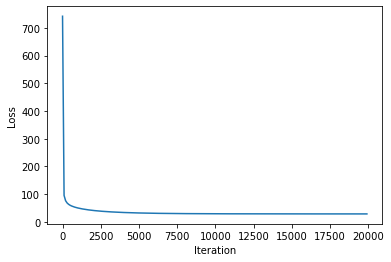

In [13]:
x_train_n, y_train_n = select_model(x_train_set, y_train_set, range(0,18), 2)
x_val_n, y_val_n = select_model(x_validation, y_validation, range(0,18), 2)
#w_p, error = calWeightGD(x_train_n, y_train_n, x_val_n, y_val_n, 120000, 0.0016, True)
w_p, error = calWeightAdagrad(x_train_n, y_train_n, x_val_n, y_val_n, 20000, 2, True)
error

In [14]:
import csv
def saveSubmit(ans_y):
  with open('submit.csv', mode='w', newline='') as submit_file:
    csv_writer = csv.writer(submit_file)
    header = ['id', 'value']
    print(header)
    csv_writer.writerow(header)
    for i in range(240):
        row = ['id_' + str(i), ans_y[i][0]]
        csv_writer.writerow(row)
        print(row)

In [15]:
testdata = pd.read_csv('./test.csv', header = None, encoding = 'big5')
test_data = testdata.iloc[:, 2:]
test_data[test_data == 'NR'] = 0
test_data = test_data.to_numpy() #4320x9
test_x = np.empty([240, 18*9], dtype = float) #=> 4320/18 = 240
for i in range(240):
    test_x[i, :] = test_data[18 * i: 18* (i + 1), :].reshape(1, -1)  # i col <= 18x9
for i in range(len(test_x)):
    for j in range(len(test_x[0])):
        if std_x[j] != 0:
            test_x[i][j] = (test_x[i][j] - mean_x[j]) / std_x[j]
test_x = np.concatenate((np.ones([240, 1]), test_x), axis = 1).astype(float)
test_x

<ipython-input-15-455fe22ace2c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[test_data == 'NR'] = 0
C:\Users\willi\anaconda3\lib\site-packages\pandas\core\frame.py:3089: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


array([[ 1.        , -0.24447681, -0.24545919, ..., -0.67065391,
        -1.04594393,  0.07797893],
       [ 1.        , -1.35825331, -1.51789368, ...,  0.17279117,
        -0.10906991, -0.48454426],
       [ 1.        ,  1.5057434 ,  1.34508393, ..., -1.32666675,
        -1.04594393, -0.57829812],
       ...,
       [ 1.        ,  0.3919669 ,  0.54981237, ...,  0.26650729,
        -0.20275731,  1.20302531],
       [ 1.        , -1.8355861 , -1.8360023 , ..., -1.04551839,
        -1.13963133, -1.14082131],
       [ 1.        , -1.35825331, -1.35883937, ...,  2.98427476,
         3.26367657,  1.76554849]])

In [16]:
x_test_n, y_test_n = select_model(test_x, 0, range(0,18), 2)
x_test_n = np.concatenate((np.ones([x_test_n.shape[0], 1]), x_test_n), axis = 1).astype(float)
test_y_sel = np.dot(x_test_n, w_p)
saveSubmit(test_y_sel)

['id', 'value']
['id_0', 7.8597356297911585]
['id_1', 16.652449265524517]
['id_2', 34.46087286733575]
['id_3', 10.440526103996064]
['id_4', 30.25377141614918]
['id_5', 21.971197439850172]
['id_6', 24.524775835019387]
['id_7', 41.36738000984028]
['id_8', 29.02451687869296]
['id_9', 58.84706278811085]
['id_10', 23.238495031274798]
['id_11', 17.08653817604999]
['id_12', 52.12520415147961]
['id_13', 56.902740722965206]
['id_14', 17.40371685926249]
['id_15', 4.078070099508608]
['id_16', 30.128833561787268]
['id_17', 64.75790938611537]
['id_18', 2.0352226297575555]
['id_19', 17.17554906777997]
['id_20', 45.340788954530595]
['id_21', 63.36364747283158]
['id_22', 8.00144658253858]
['id_23', 16.19106912074051]
['id_24', 11.279679793147807]
['id_25', 38.297272002276074]
['id_26', 11.914142455310122]
['id_27', 79.40132869665703]
['id_28', 12.366043998934405]
['id_29', 63.197374740001166]
['id_30', 18.14940454733174]
['id_31', 12.80748616640565]
['id_32', 29.350685596742963]
['id_33', 39.099091069